In [1]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/PangeAI/Documents/work/scalexa/pangeaai/optimize-cosine'

In [2]:
# from cudams import cosine, data, utils
from cudams.utils import argbatch, mkdir
from cudams.data import get_ref_spectra_from_df
from cudams.kernel import compile
from cudams.utils import name2idx
from cudams.cosine import similarity
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from cudams.data import spectra_peaks_to_tensor
from cudams.processor import Config
from numba import cuda
from itertools import product
from time import perf_counter
from multiprocessing.pool import ThreadPool
from multiprocessing import shared_memory
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

assert cuda.is_available()

In [5]:
## Define constants
tolerance: float = 0.1
shift: float = 0
mz_power: float = 0
int_power: float = 1

## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 1000

# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 512

## GPU-specific constants
THREADS_PER_BLOCK = (32, 32)
BLOCKS_PER_GRID_X = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[0])
BLOCKS_PER_GRID_Y = math.ceil(BATCH_SIZE / THREADS_PER_BLOCK[1])
BLOCKS_PER_GRID = (BLOCKS_PER_GRID_X, BLOCKS_PER_GRID_Y)

# Since Greedy cosine is an unstable algorithm, because approximate mz-mz values do not
# result in approximately the same scores and number of matches.
# So we need to use fp64 to minimize the deviation as much as possible.
# Using float32 causes a significant speedup in the processing speed.
dtype = 'float64'

# Data path
reference_csv_file = Path("data/input/test_set_cosine.csv")
query_csv_file = Path("data/input/test_set_cosine.csv")

# Limits
# We consider only first LIMIT number of entries in CSVs
LIMIT = 2048

# For keeping track of experiments

CONFIG = Config(
    tolerance = tolerance,
    shift = shift,
    mz_power = mz_power,
    int_power = int_power,
    dtype = dtype,
    reference_csv_file = reference_csv_file,
    query_csv_file = query_csv_file,
    BATCH_SIZE = BATCH_SIZE,
    MATCH_LIMIT = MATCH_LIMIT,
    LIMIT = LIMIT,
)

CONFIG_DEFAULT = CONFIG.model_copy()

config_str = CONFIG.model_dump_json(indent=1)
experiment_hash = abs(hash(config_str))
output_dir = mkdir(Path(f'data/experiments/{experiment_hash}'))
(output_dir / 'config.json').write_text(config_str)
print(config_str)

{
 "tolerance": 0.1,
 "shift": 0.0,
 "mz_power": 0,
 "int_power": 1,
 "dtype": "float64",
 "reference_csv_file": "data/input/test_set_cosine.csv",
 "query_csv_file": "data/input/test_set_cosine.csv",
 "BATCH_SIZE": 1000,
 "MATCH_LIMIT": 512,
 "LIMIT": 2048
}


In [6]:
# We load CSV files using multiple threads
ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df)

print(f"We have {len(references)} references and {len(queries)} queries")

100%|██████████| 10000/10000 [00:02<00:00, 3797.13it/s]


We have 9738 references and 9738 queries


In [7]:
# # ! rm -r data/tests/d7/*
# cpu_output_dir = mkdir(output_dir / 'cpu', clean=True)
# refs = list([r.peaks.to_numpy for r in references])
# ques = list([q.peaks.to_numpy for q in queries])

# rlims = argbatch(refs, BATCH_SIZE)
# qlims = argbatch(ques, BATCH_SIZE)

# batches_rq = list(product(rlims, qlims))

# for (rstart, rend), (qstart, qend) in tqdm(batches_rq, total=len(batches_rq)):
#     rspec = refs[rstart:rend]
#     qspec = ques[qstart:qend]
#     out_true = np.full((BATCH_SIZE, BATCH_SIZE, 2), fill_value=0, dtype='float32')
#     for (i, spec1), (j, spec2) in product(enumerate(rspec), enumerate(qspec)):
#             score = similarity(
#                 spec1,
#                 spec2,
#                 tolerance=tolerance,
#                 shift=shift,
#                 mz_power=mz_power,
#                 int_power=int_power,
#             )
#             if score is not None:
#                 out_true[i,j,0] = score[0]
#                 out_true[i,j,1] = score[1]
#     np.save(cpu_output_dir / f'{rstart}-{rend}.{qstart}-{qend}.score.npy', out_true)

# Error analysis

In [7]:
R = math.ceil( len(references) / BATCH_SIZE ) * BATCH_SIZE
Q = math.ceil( len(queries) / BATCH_SIZE ) * BATCH_SIZE

C = np.empty((R,Q,2), dtype='float32')

scores = sorted(cpu_output_dir.glob('*.score.npy'))
for score in scores:
    rstart, rend, qstart, qend = name2idx(score)
    chunk = np.load(score)
    C[rstart:rend, qstart:qend] = chunk

# Match Limit vs. Overflow probability

In [10]:
from cudams.processor import CudaCosineGreedy

output_dir = mkdir(Path(f'data/experiments/{experiment_hash}'))
(output_dir / 'config.json').write_text(config_str)
print(output_dir)

cures = []
for MATCH_LIMIT in np.logspace(0, 9, 20, base=2, dtype='int'): 
    kernel = compile(tolerance=tolerance, shift=shift, 
                    mz_power=mz_power, int_power=int_power, 
                    match_limit=MATCH_LIMIT, batch_size=BATCH_SIZE)
    ccg = CudaCosineGreedy(config=CONFIG, 
                           kernel=kernel, 
                           output_dir=mkdir(output_dir/'gpu'/str(MATCH_LIMIT), clean=True))
    cures.append([MATCH_LIMIT, ccg(references=references, queries=queries)])

data/experiments/640602409432003560


Batch all references: 0it [00:00, ?it/s]

Batch all references: 2it [00:00, 27.02it/s]
Batch all queries: 2it [00:00, 32.89it/s]
100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


[PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 28.52it/s]
Batch all queries: 2it [00:00, 32.08it/s]
100%|██████████| 4/4 [00:00<00:00,  6.24it/s]


[PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 32.63it/s]
Batch all queries: 2it [00:00, 33.54it/s]
100%|██████████| 4/4 [00:00<00:00,  6.26it/s]


[PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/1/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 28.57it/s]
Batch all queries: 2it [00:00, 33.91it/s]
100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


[PosixPath('data/experiments/640602409432003560/gpu/2/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/2/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 34.06it/s]
Batch all queries: 2it [00:00, 32.48it/s]
100%|██████████| 4/4 [00:00<00:00,  6.03it/s]


[PosixPath('data/experiments/640602409432003560/gpu/3/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/3/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 33.15it/s]
Batch all queries: 2it [00:00, 33.01it/s]
100%|██████████| 4/4 [00:00<00:00,  6.31it/s]


[PosixPath('data/experiments/640602409432003560/gpu/5/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/5/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 35.02it/s]
Batch all queries: 2it [00:00, 34.67it/s]
100%|██████████| 4/4 [00:00<00:00,  6.14it/s]


[PosixPath('data/experiments/640602409432003560/gpu/7/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/7/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 34.75it/s]
Batch all queries: 2it [00:00, 35.67it/s]
100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


[PosixPath('data/experiments/640602409432003560/gpu/9/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/9/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 27.87it/s]
Batch all queries: 2it [00:00, 34.20it/s]
100%|██████████| 4/4 [00:00<00:00,  6.36it/s]


[PosixPath('data/experiments/640602409432003560/gpu/13/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/13/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 35.56it/s]
Batch all queries: 2it [00:00, 34.92it/s]
100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


[PosixPath('data/experiments/640602409432003560/gpu/19/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/19/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 34.45it/s]
Batch all queries: 2it [00:00, 34.87it/s]
100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


[PosixPath('data/experiments/640602409432003560/gpu/26/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/26/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 32.46it/s]
Batch all queries: 2it [00:00, 33.99it/s]
100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


[PosixPath('data/experiments/640602409432003560/gpu/37/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/37/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 33.36it/s]
Batch all queries: 2it [00:00, 29.20it/s]
100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


[PosixPath('data/experiments/640602409432003560/gpu/51/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/51/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 32.09it/s]
Batch all queries: 2it [00:00, 32.66it/s]
100%|██████████| 4/4 [00:00<00:00,  5.08it/s]


[PosixPath('data/experiments/640602409432003560/gpu/71/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/71/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 30.29it/s]
Batch all queries: 2it [00:00, 34.50it/s]
100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


[PosixPath('data/experiments/640602409432003560/gpu/99/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/99/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 31.66it/s]
Batch all queries: 2it [00:00, 33.65it/s]
100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


[PosixPath('data/experiments/640602409432003560/gpu/137/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/137/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 25.95it/s]
Batch all queries: 2it [00:00, 27.86it/s]
100%|██████████| 4/4 [00:01<00:00,  3.29it/s]


[PosixPath('data/experiments/640602409432003560/gpu/191/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/191/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 23.09it/s]
Batch all queries: 2it [00:00, 31.32it/s]
100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


[PosixPath('data/experiments/640602409432003560/gpu/265/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/265/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 29.15it/s]
Batch all queries: 2it [00:00, 32.60it/s]
100%|██████████| 4/4 [00:01<00:00,  3.96it/s]


[PosixPath('data/experiments/640602409432003560/gpu/368/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/368/1024-2048.1024-2048.score.npy')]
8 4


Batch all references: 2it [00:00, 34.20it/s]
Batch all queries: 2it [00:00, 33.34it/s]
100%|██████████| 4/4 [00:01<00:00,  3.67it/s]

[PosixPath('data/experiments/640602409432003560/gpu/512/0-1024.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/0-1024.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/0-1024.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/0-1024.1024-2048.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/1024-2048.0-1024.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/1024-2048.0-1024.score.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/1024-2048.1024-2048.ovfl.npy'), PosixPath('data/experiments/640602409432003560/gpu/512/1024-2048.1024-2048.score.npy')]
8 4


In [11]:
x = []
y = []
for ml, res in tqdm(cures):
    s,ov = res.to_full_matrix()
    x.append(ml)
    y.append(ov.mean())

100%|██████████| 20/20 [00:00<00:00, 57.45it/s]


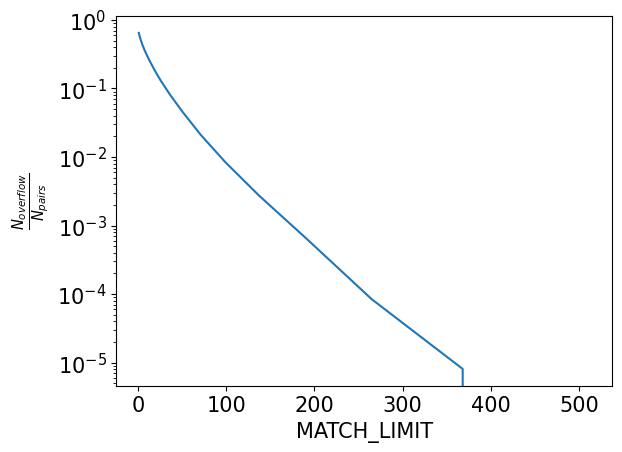

In [12]:
plt.semilogy(x,y)
plt.xlabel("MATCH_LIMIT")
plt.ylabel("# Overflows")
plt.show();

# Tolerance vs. Num overflows at given Match limit

In [29]:
from cudams.processor import CudaCosineGreedy

cures = []
x_ax = []
y_ax = []
for tolerance in np.logspace(-5, 0, 20, base=2, dtype='float64'):
    tolerance = float(tolerance)
    cosine = CudaCosineGreedy(
        tolerance=tolerance,
        mz_power=.0,
        intensity_power=1, 
        shift=0,
        batch_size=1024,
        match_limit=256,
    )
    cosine.compile()
    score, overflow = cosine.matrix(
        references=references, 
        queries=queries, 
        array_type="numpy"
    )
    y_ax.append([overflow.mean()])
    x_ax.append(tolerance)

Batch all references: 0it [00:00, ?it/s]

Batch all references: 2it [00:00, 27.84it/s]
Batch all queries: 2it [00:00, 29.56it/s]
100%|██████████| 4/4 [00:01<00:00,  3.54it/s]
Batch all references: 2it [00:00, 18.90it/s]
Batch all queries: 2it [00:00, 16.63it/s]
100%|██████████| 4/4 [00:01<00:00,  2.93it/s]
Batch all references: 2it [00:00, 25.06it/s]
Batch all queries: 2it [00:00, 28.99it/s]
100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
Batch all references: 2it [00:00, 18.20it/s]
Batch all queries: 2it [00:00, 16.36it/s]
100%|██████████| 4/4 [00:01<00:00,  3.56it/s]
Batch all references: 2it [00:00, 24.56it/s]
Batch all queries: 2it [00:00, 25.73it/s]
100%|██████████| 4/4 [00:01<00:00,  3.57it/s]
Batch all references: 2it [00:00, 27.83it/s]
Batch all queries: 2it [00:00, 19.52it/s]
100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
Batch all references: 2it [00:00, 32.43it/s]
Batch all queries: 2it [00:00, 27.92it/s]
100%|██████████| 4/4 [00:01<00:00,  2.49it/s]
Batch all references: 2it [00:00, 29.77it/s]
Batch all queries: 2it [

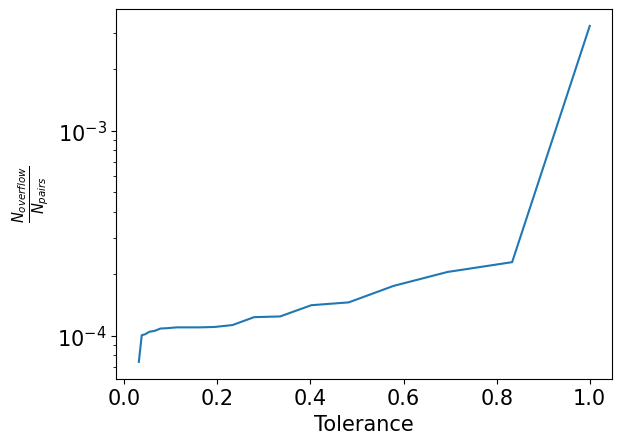

In [32]:
plt.semilogy(x_ax,y_ax)
plt.xlabel(r"Tolerance")
plt.ylabel(r"$\frac{N_{overflow}}{N_{pairs}}$")
plt.show();

## Tolerance vs. Accuracy, excluding overflows

In [ ]:
LIMIT = 512
BATCH_SIZE = 256

# We load CSV files using multiple threads
ref_spectra_df_path = Path(reference_csv_file)
ref_spectra_df = pd.read_csv(ref_spectra_df_path)
references = get_ref_spectra_from_df(ref_spectra_df, limit=LIMIT)

query_spectra_df_path = Path(query_csv_file)
query_spectra_df = pd.read_csv(query_spectra_df_path)
queries = get_ref_spectra_from_df(query_spectra_df, limit=LIMIT)

print(f"We have {len(references)} references and {len(queries)} queries")


In [70]:
from cudams.processor import CudaCosineGreedy, CpuCosineGreedy
from collections import defaultdict
from cudams.utils import mute

df = defaultdict(list)

for tolerance in tqdm(np.logspace(-8, 0, 15, base=2, dtype='float64')):
    with mute():
        tolerance = float(tolerance)
        cosine = CudaCosineGreedy(
            tolerance=tolerance,
            mz_power=0,
            intensity_power=1, 
            shift=0,
            batch_size=BATCH_SIZE,
            match_limit=512,
        )
        cosine.compile()
        score, overflow = cosine.matrix(
            references=references, 
            queries=queries, 
            array_type="numpy"
        )
        cpu_cosine = CpuCosineGreedy(
            tolerance=tolerance,
            mz_power=0,
            intensity_power=1, 
            shift=0,
            batch_size=BATCH_SIZE
        )
        score_true = cpu_cosine.matrix(
            references=references, 
            queries=queries, 
            array_type="numpy"
        )
        x_ax
        overflow = overflow.squeeze()
        acc_score = np.isclose(score[...,0], score_true[...,0])
        acc_num_match = np.isclose(score[...,1], score_true[...,1])
        df['tolerance'].append(tolerance)
        df['acc_score'].append(acc_score.mean())
        df['acc_num_match'].append(acc_score.mean())
        df['overflows'].append(overflow.mean())

0.00390625


Batch all references: 0it [00:00, ?it/s]

Batch all references: 2it [00:00, 105.55it/s]
Batch all queries: 2it [00:00, 85.84it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  3.97it/s]


0.005804665191941204


Batch all references: 2it [00:00, 88.76it/s]
Batch all queries: 2it [00:00, 88.86it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  3.90it/s]


0.008625699325576656


Batch all references: 2it [00:00, 84.53it/s]
Batch all queries: 2it [00:00, 98.15it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  3.10it/s]


0.012817739937619343


Batch all references: 2it [00:00, 76.24it/s]
Batch all queries: 2it [00:00, 71.15it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  2.80it/s]


0.019047088346944928


Batch all references: 2it [00:00, 79.48it/s]
Batch all queries: 2it [00:00, 64.86it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


0.028303864508247074


Batch all references: 2it [00:00, 48.92it/s]
Batch all queries: 2it [00:00, 60.78it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:01<00:00,  2.46it/s]


0.04205938101976114


Batch all references: 2it [00:00, 59.97it/s]
Batch all queries: 2it [00:00, 50.37it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.95it/s]


0.0625


Batch all references: 2it [00:00, 49.76it/s]
Batch all queries: 2it [00:00, 45.73it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


0.09287464307105926


Batch all references: 2it [00:00, 75.79it/s]
Batch all queries: 2it [00:00, 54.44it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


0.1380111892092265


Batch all references: 2it [00:00, 49.05it/s]
Batch all queries: 2it [00:00, 49.03it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


0.20508383900190938


Batch all references: 2it [00:00, 80.45it/s]
Batch all queries: 2it [00:00, 89.81it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


0.30475341355111885


Batch all references: 2it [00:00, 98.06it/s]
Batch all queries: 2it [00:00, 96.87it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


0.4528618321319532


Batch all references: 2it [00:00, 92.67it/s]
Batch all queries: 2it [00:00, 84.71it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


0.6729500963161777


Batch all references: 2it [00:00, 76.34it/s]
Batch all queries: 2it [00:00, 70.67it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


1.0


Batch all references: 2it [00:00, 85.37it/s]
Batch all queries: 2it [00:00, 98.26it/s]
  0%|          | 0/4 [00:00<?, ?it/s]/home/PangeAI/miniconda3/envs/pb2/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Text(0, 0.5, 'Accuracy')

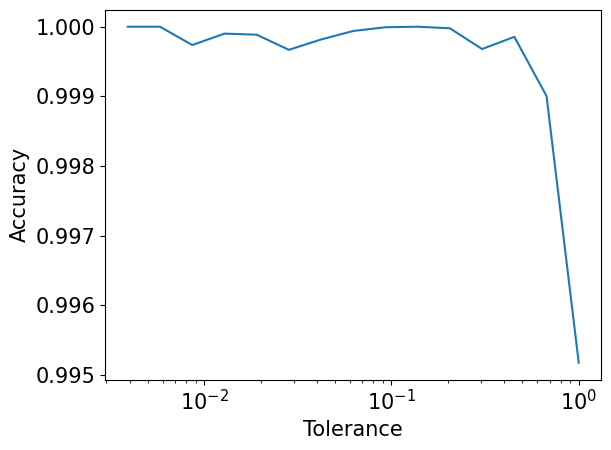

In [71]:
df = pd.DataFrame(df)
plt.semilogx(df.tolerance, df.acc_score)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Overflows')

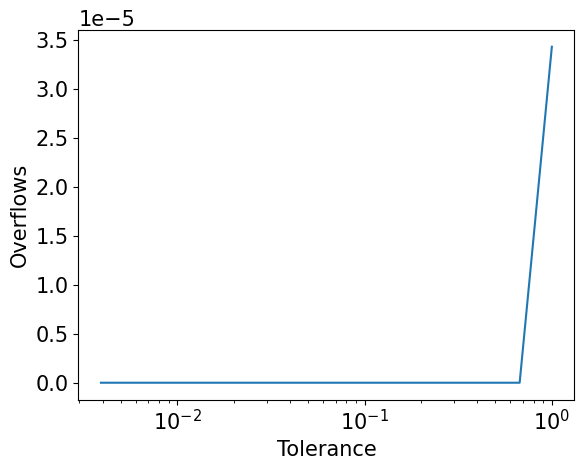

In [74]:
df = pd.DataFrame(df)
plt.semilogx(df.tolerance, df.overflows)
plt.xlabel("Tolerance")
plt.ylabel("Overflows")

# Accuracy vs. 

In [36]:
# acc_score.mean()
score_true

array([[[ 1.        , 14.        ],
        [ 0.98699003,  8.        ],
        [ 0.97711813,  7.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.98699003,  8.        ],
        [ 1.        , 15.        ],
        [ 0.9898711 , 10.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.97711813,  7.        ],
        [ 0.9898711 , 10.        ],
        [ 1.        , 14.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       ...,

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ],
        [ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ],
        [ 0.        ,  0.  

# Error analysis

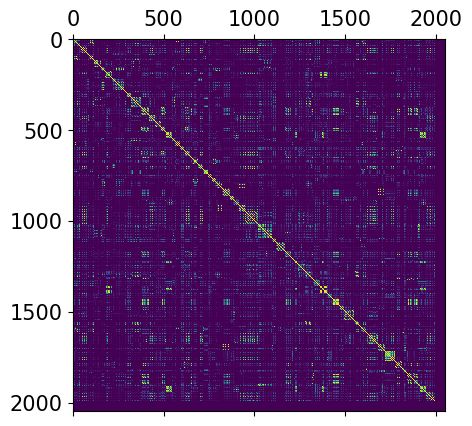

In [80]:
import matplotlib.pyplot as plt

plt.matshow(s[...,0])
plt.show()

In [19]:
experiment_hash

7037845401422292691

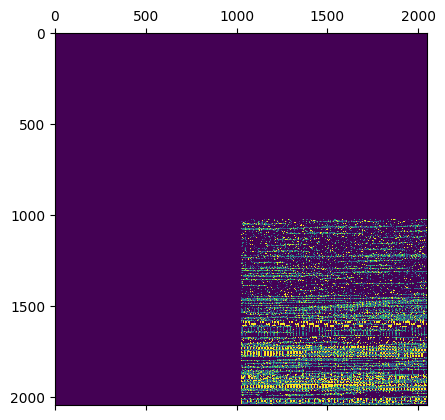

In [18]:
plt.matshow(ov.squeeze())